# <font color=#FF7F50><center> Supervised ML to predict movie ratings with regression

In [1]:
from skimage.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor

import data_cleaning
from importlib import reload
reload(data_cleaning)
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, \
    r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('tmdb_5000_movies.csv')
df.drop(columns=['homepage', 'id', 'overview', 'tagline', 'vote_count'], inplace=True)

In [35]:
df

,budget,genres,keywords,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
1,300000000,Other,ocean,en,Pirates of the Caribbean: At World's End,139.082615,Walt Disney Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,English,Released,Pirates of the Caribbean: At World's End,6.9
2,245000000,Other,spy,en,Spectre,107.376788,Columbia Pictures,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,Fran\u00e7ais,Released,Spectre,6.3
3,250000000,Other,dc comics,en,The Dark Knight Rises,112.312950,Legendary Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,English,Released,The Dark Knight Rises,7.6
4,260000000,Other,based on novel,en,John Carter,43.926995,Walt Disney Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,English,Released,John Carter,6.1
5,258000000,Other,dual identity,en,Spider-Man 3,115.699814,Columbia Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,890871626,139.0,English,Released,Spider-Man 3,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,27000,"[{""id"": 35, ""name"": ""Comedy""}]",salesclerk,en,Clerks,19.748658,Miramax Films,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-13,3151130,92.0,English,Released,Clerks,7.4
4788,12000,Other,gay,en,Pink Flamingos,4.553644,Dreamland Productions,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1972-03-12,6000000,93.0,English,Released,Pink Flamingos,6.2
4792,20000,Other,japan,Other,キュア,0.212443,Daiei Studios,Other,1997-11-06,99000,111.0,\u65e5\u672c\u8a9e,Released,Cure,7.4
4796,7000,Other,distrust,en,Primer,23.307949,Thinkfilm,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-10-08,424760,77.0,English,Released,Primer,6.9


# <font color=#FF7F50><center>Data Cleaning

In [3]:
# Reduce cardinality
# Create lists of most common categories
top_10_genres = df['genres'].value_counts()[:10].index.tolist()
top_5_languages = df['original_language'].value_counts()[:5].index.tolist()
top_5_production_countries = df['production_countries'].value_counts()[:5].index.tolist()
# Everything else gets replaced with 'Other'
df['genres'] = df['genres'].apply(lambda x: 'Other' if x not in top_10_genres else x)
df['original_language'] = df['original_language'].apply(lambda x: 'Other' if x not in top_5_languages else x)
df['production_countries'] = df['production_countries'].apply(lambda x: 'Other' if x not in top_5_production_countries else x)

In [4]:
# Get first word of columns with many words/categories, such as "name" : 'Action', "name" :'Drama'... -> 'Action'
data_cleaning.first_word_within_quotes_dataframe(df)
df.drop(df.loc[df.revenue == df.revenue.max()].index, inplace=True)

In [5]:
# Dropping zeroes
df.drop(df.loc[df.vote_average == 0].index, inplace=True)
df.drop(df.loc[df.budget == 0].index, inplace=True)
df.drop(df.loc[df.revenue == 0].index, inplace=True)

# <font color=#FF7F50><center>EDA

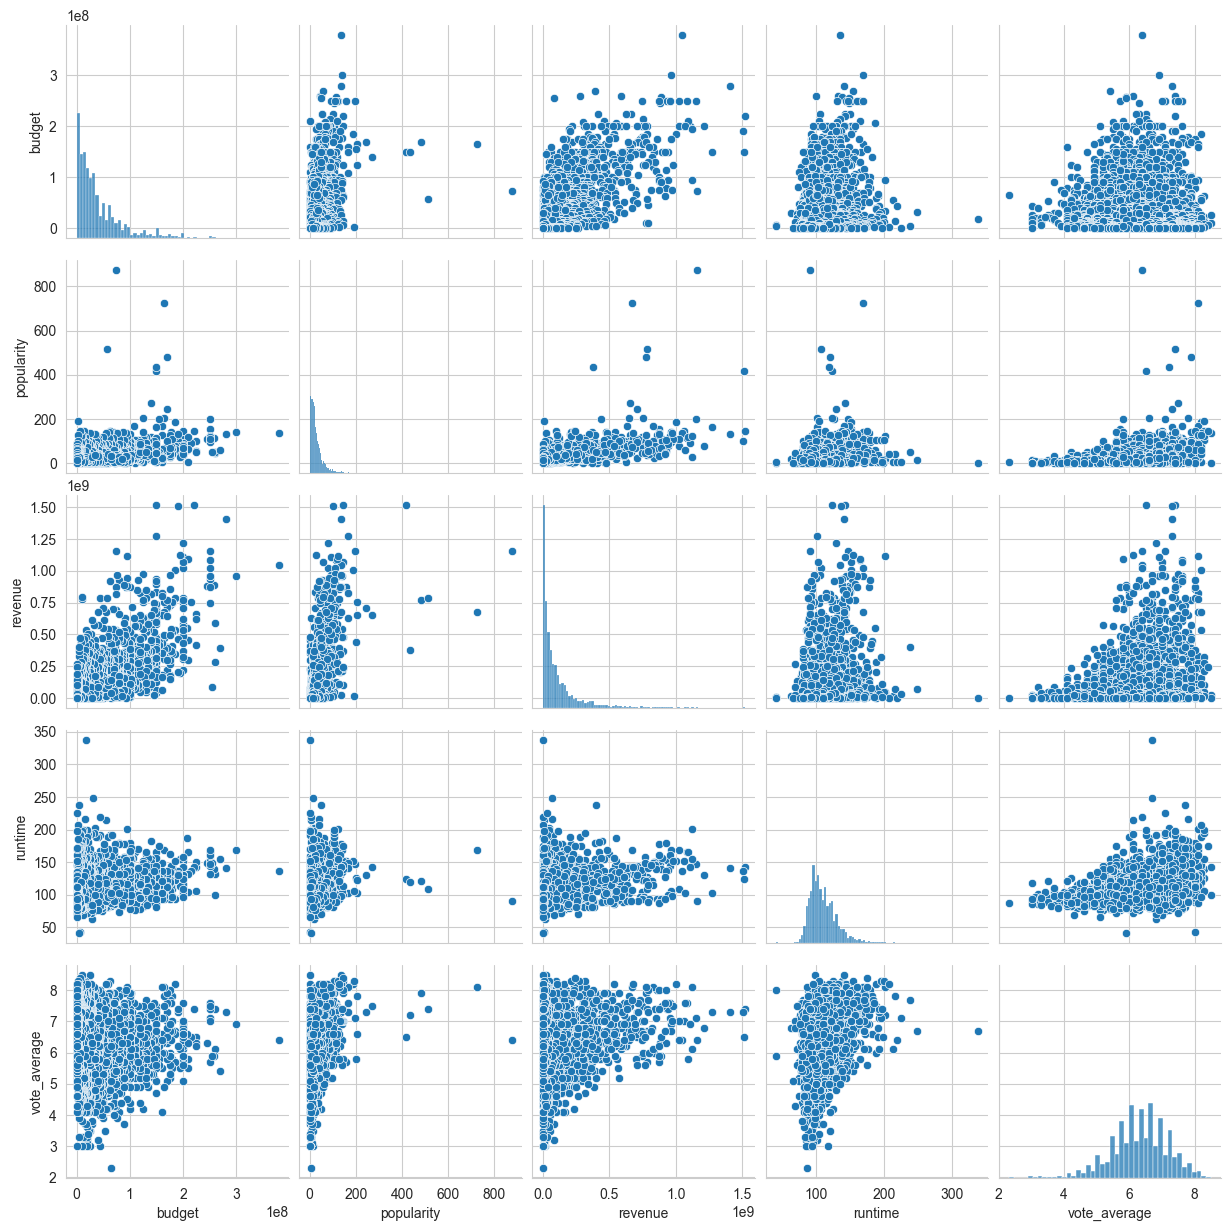

In [1021]:
sns.pairplot(df)

look at
- popularity vs vote_average
- budget vs revenue, how often it's profitable
- budget vs vote_average
- distribution of vote_average
- outliers with boxplot

## outliers

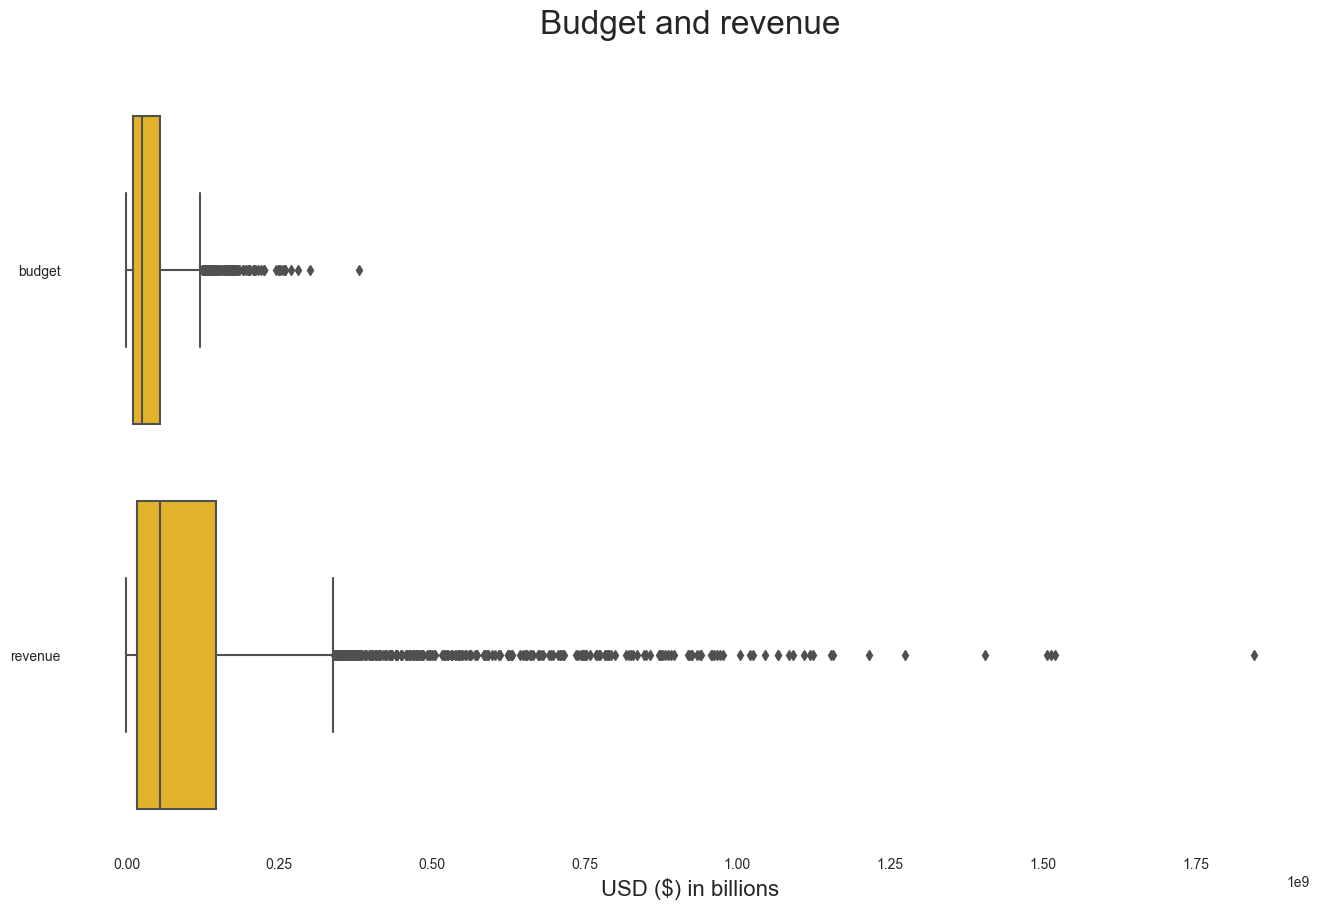

In [42]:
plt.figure(figsize=(16,10))
sns.boxplot(data=df[['budget', 'revenue']], orient='horizontal', color='#FEC20C')
plt.title('Budget and revenue\n', fontsize=24)
plt.xlabel('USD ($) in billions', fontsize=16)
plt.grid(False)
sns.despine(bottom = True, left = True)
plt.savefig(transparent=True, fname='popularity_vs_rating.png', dpi=1000)

## popularity vs vote_average

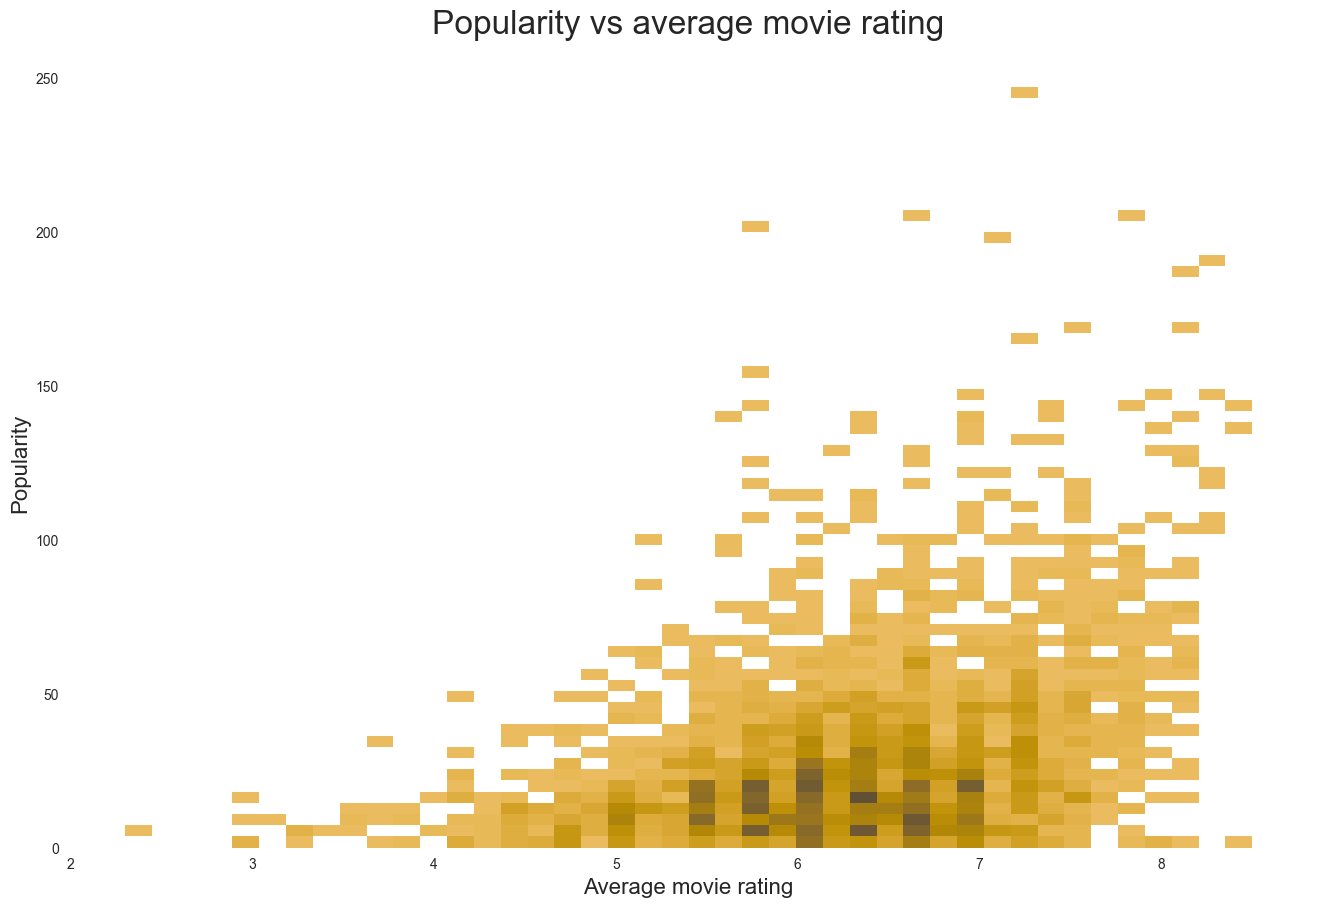

In [38]:
figure = plt.figure(figsize=(16,10))
pop_vote = sns.histplot(data=df, y=df.popularity, x=df.vote_average, color='#FEC20C')
pop_vote.set(ylim=(0, 250))
plt.xlabel('Average movie rating', fontsize=16)
plt.ylabel('Popularity', fontsize=16)
plt.grid(False)
plt.title('Popularity vs average movie rating\n', fontsize=24)
sns.despine(bottom = True, left = True)
plt.savefig(transparent=True, fname='popularity_vs_rating.png', dpi=1000)

## Budget vs revenue

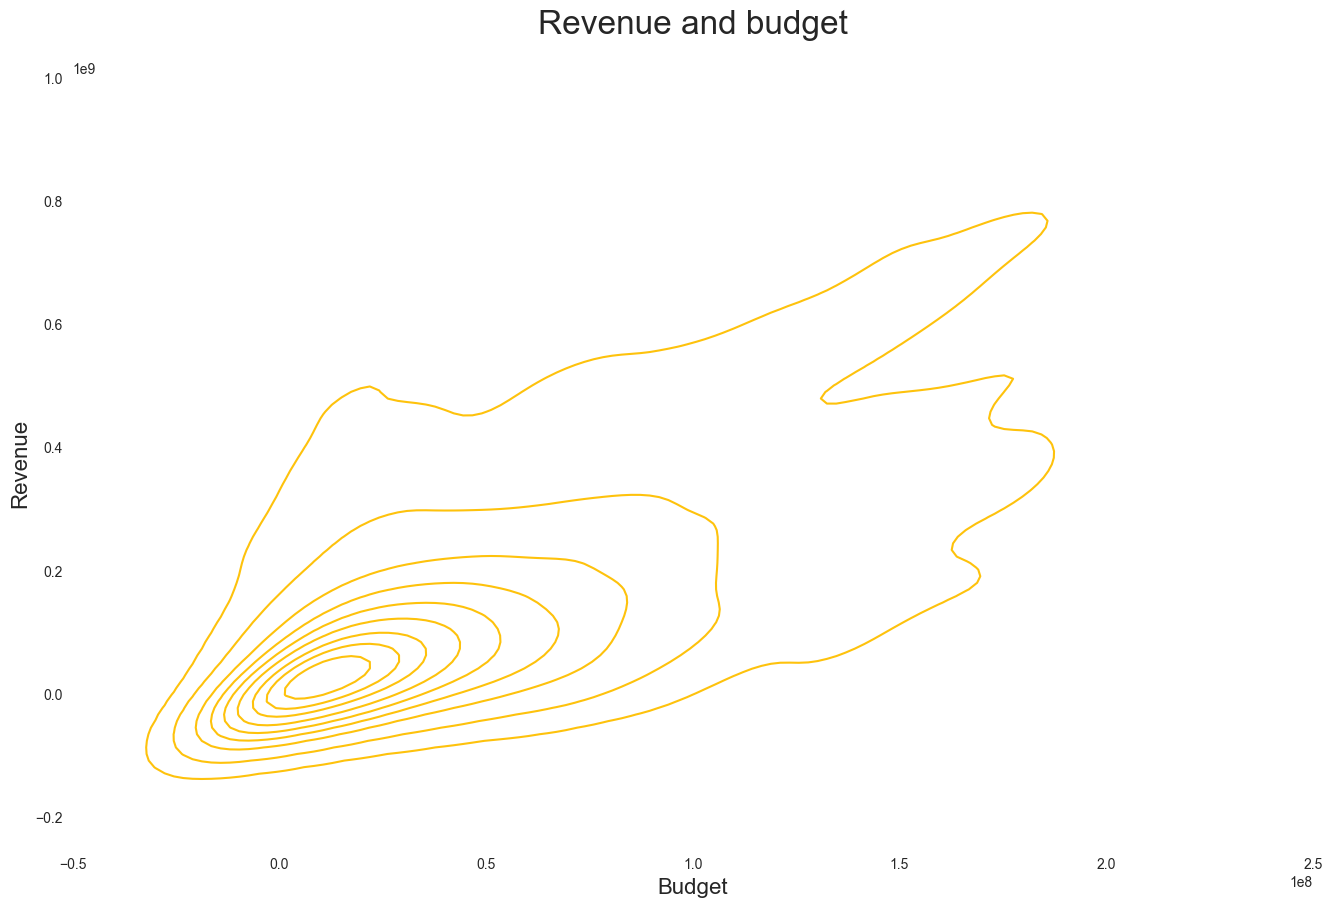

In [50]:
figure = plt.figure(figsize=(16,10))
pop_vote = sns.kdeplot(data=df, y=df.revenue, x=df.budget, color='#FEC20C')
pop_vote.set(ylim=(-0.25e9, 1e9), xlim=(-0.05e9, .25e9))

plt.xlabel('Budget', fontsize=16)
plt.ylabel('Revenue', fontsize=16)
plt.grid(False)
plt.title('Revenue and budget\n', fontsize=24)
sns.despine(bottom = True, left = True)
plt.savefig(transparent=True, fname='popularity_vs_rating.png', dpi=1000)

# <font color=#FF7F50><center>Build models

## Train test split

In [9]:
target_var = 'vote_average'
X = df.drop(columns=['vote_average'])
y = df[target_var]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

## Baseline model

In [11]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)

mae_baseline = mean_absolute_error(y_true=y_test, y_pred=y_pred)
mse_baseline = mean_squared_error(y_test, y_pred)

print(f'mae baseline: {mae_baseline}\nmse baseline: {mse_baseline}')

mae baseline: 0.6965321477428181
mse baseline: 0.7367679677492813


## Testing different regressors

In [12]:
num_features = ['budget', 'runtime', 'revenue', 'popularity']
cat_features = ['genres', 'original_language', 'production_countries']

num_trans = make_pipeline(SimpleImputer(strategy='mean'),
                          RobustScaler())
cat_trans = make_pipeline(SimpleImputer(strategy='most_frequent'),
                          OneHotEncoder(handle_unknown='ignore', drop='if_binary'))

preprocessor = make_column_transformer((num_trans, num_features),
                                       (cat_trans, cat_features))
classifiers = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_jobs=-1),
    SVR(),
    KNeighborsRegressor(n_jobs=-1),
    XGBRegressor()
    ]

for classifier in classifiers:

    pipe = make_pipeline(preprocessor, classifier)
    grid = GridSearchCV(estimator=pipe, param_grid={}, cv=5, scoring='r2')
    grid.fit(X_train, y_train)

    print(f'Train score for {classifier}: {grid.best_score_}\n')

Train score for LinearRegression(): 0.30917732545860216

Train score for DecisionTreeRegressor(): -0.1298642254316046

Train score for RandomForestRegressor(n_jobs=-1): 0.42116150085427184

Train score for SVR(): 0.4464357971760836

Train score for KNeighborsRegressor(n_jobs=-1): 0.3494497826847275

Train score for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=N

# <font color=#FF7F50><center>Tune best models

## SVR

In [13]:
param_grid_svr = {
    'svr__C':[.1, .5, 1, 1.5, 2, 4],
    'svr__gamma':['scale', 'auto'],
    'svr__kernel':['linear', 'poly', 'rbf', 'sigmoid']
}

pipe = make_pipeline(preprocessor, SVR())
grid_svr = GridSearchCV(pipe, param_grid=param_grid_svr, scoring='r2', cv=5)
grid_svr.fit(X_train, y_train)

print('Best score:', grid_svr.best_score_)
print('Best params:', grid_svr.best_params_)

Best score: 0.4464357971760836
Best params: {'svr__C': 1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


## RandomForest

In [14]:
param_grid_rf = {
    'randomforestregressor__min_samples_leaf':[1, 2, 4, 6, 8],
    'randomforestregressor__max_depth':[10, 50, 100, None],
    'randomforestregressor__n_estimators':[50, 100, 150, 200],
    'randomforestregressor__criterion':['poisson', 'friedman_mse']
}

classifier = RandomForestRegressor(n_jobs=-1)
pipe = make_pipeline(preprocessor, classifier)

grid_rf = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2'
)

grid_rf.fit(X_train, y_train)

print(f'Best score: {grid_rf.best_score_}')
print(f'Best params: {grid_rf.best_params_}')

Best score: 0.4331089239550695
Best params: {'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': 200}


# <font color=#FF7F50><center>Predict on training data

## SVR

In [15]:
best_model_svr = grid_svr.best_estimator_
best_model_svr.fit(X_train, y_train);
y_pred = best_model_svr.predict(X_train)
print(f'Mean absolute error: {round(mean_absolute_error(y_true=y_train, y_pred=y_pred), 4)}')
print(f'r2 score: \t\t\t {round(r2_score(y_train, y_pred), 4)}')

Mean absolute error: 0.4482
r2 score: 			 0.5029


## RandomForest

In [16]:
best_model_rf = grid_rf.best_estimator_
best_model_rf.fit(X_train, y_train)
y_pred = best_model_rf.predict(X_train)
print(f'Mean absolute error: {round(mean_absolute_error(y_true=y_train, y_pred=y_pred), 4)}')
print(f'r2 score: \t\t\t {round(r2_score(y_train, y_pred), 4)}')

Mean absolute error: 0.3282
r2 score: 			 0.7509


# <font color=#FF7F50><center>Evaluation on test data

## SVR

In [17]:
best_model = grid_svr.best_estimator_
best_model.fit(X_test, y_test)
y_pred_svr = best_model.predict(X_test)

In [19]:
r2_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_true=y_test, y_pred=y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)

print(f'r2  svr: {round(r2_svr, 4)}\nmae svr: {round(mae_svr, 4)}\nmse svr: {round(mse_svr, 4)}')

r2  svr: 0.5381
mae svr: 0.4196
mse svr: 0.3403


## RandomForest

In [20]:
best_model = grid_rf.best_estimator_
best_model.fit(X_test, y_test)
y_pred_rf = best_model.predict(X_test)

In [22]:
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f'r2  rf: {round(r2_rf, 4)}\nmae rf: {round(mae_rf, 4)}\nmse rf: {round(mse_rf, 4)}')

r2  rf: 0.8201
mae rf: 0.2794
mse rf: 0.1325


## Quick comparison

In [29]:
y_test_reset_index = y_test.reset_index(drop=True)

In [30]:
vote_comparison = pd.DataFrame([pd.Series(y_pred_rf), y_test_reset_index]).T.rename(columns={'Unnamed 0': 'Predicted IMDB rating',
                                                                        'vote_average':'Actual IMDB rating'})

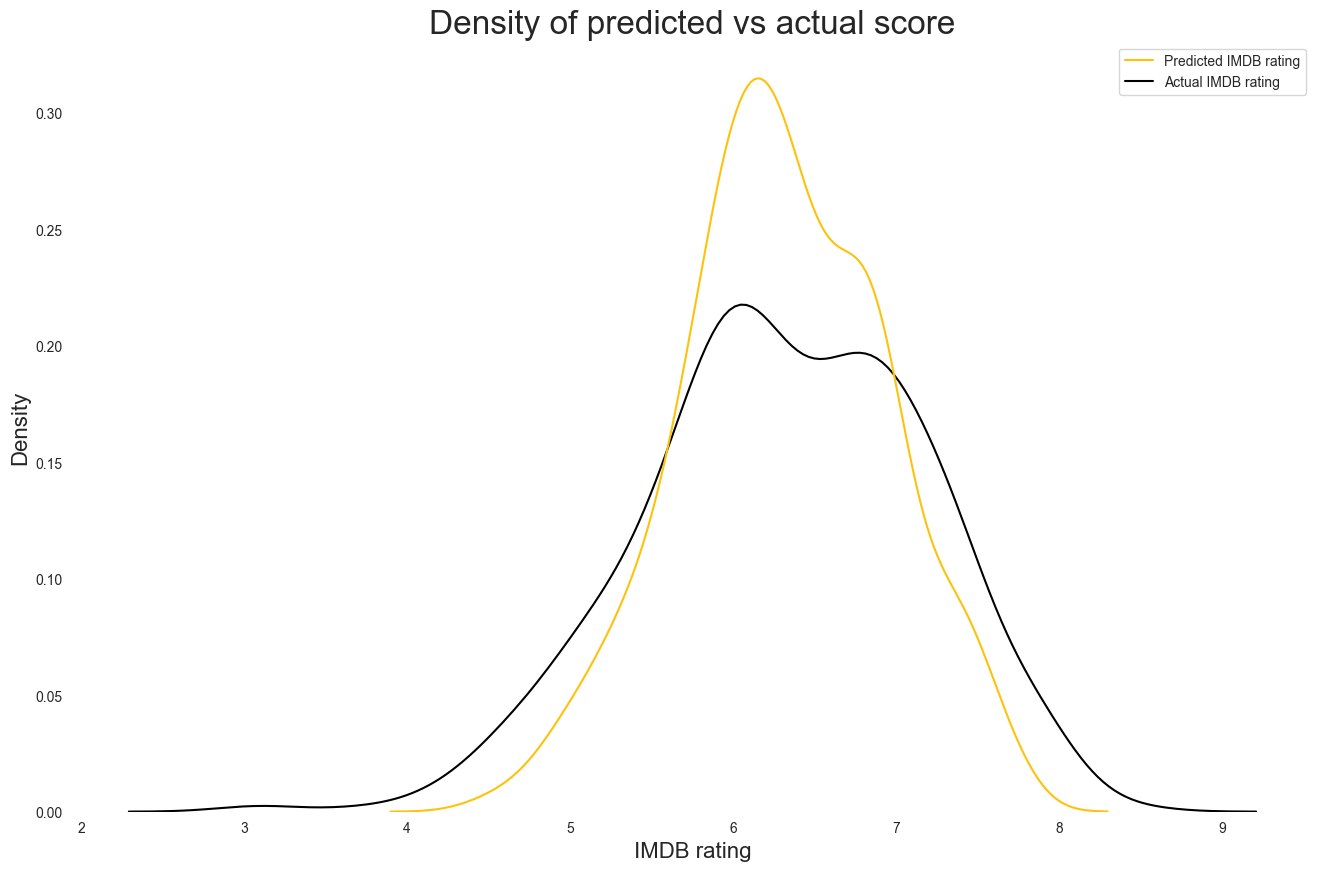

In [58]:
figure = plt.figure(figsize=(16,10))

sns.kdeplot(vote_comparison, palette=['#FEC20C', '#000000'])
plt.title('Density of predicted vs actual score', fontsize=24)
plt.xlabel('IMDB rating', fontsize=16)
plt.ylabel('Density', fontsize=16)
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.savefig(transparent=True, fname='popularity_vs_rating.png', dpi=1000)

# <font color=#FF7F50><center> Deployment

In [32]:
df

,budget,genres,keywords,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
1,300000000,Other,ocean,en,Pirates of the Caribbean: At World's End,139.082615,Walt Disney Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,English,Released,Pirates of the Caribbean: At World's End,6.9
2,245000000,Other,spy,en,Spectre,107.376788,Columbia Pictures,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,Fran\u00e7ais,Released,Spectre,6.3
3,250000000,Other,dc comics,en,The Dark Knight Rises,112.312950,Legendary Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,English,Released,The Dark Knight Rises,7.6
4,260000000,Other,based on novel,en,John Carter,43.926995,Walt Disney Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,English,Released,John Carter,6.1
5,258000000,Other,dual identity,en,Spider-Man 3,115.699814,Columbia Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,890871626,139.0,English,Released,Spider-Man 3,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,27000,"[{""id"": 35, ""name"": ""Comedy""}]",salesclerk,en,Clerks,19.748658,Miramax Films,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-13,3151130,92.0,English,Released,Clerks,7.4
4788,12000,Other,gay,en,Pink Flamingos,4.553644,Dreamland Productions,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1972-03-12,6000000,93.0,English,Released,Pink Flamingos,6.2
4792,20000,Other,japan,Other,キュア,0.212443,Daiei Studios,Other,1997-11-06,99000,111.0,\u65e5\u672c\u8a9e,Released,Cure,7.4
4796,7000,Other,distrust,en,Primer,23.307949,Thinkfilm,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-10-08,424760,77.0,English,Released,Primer,6.9


pouria - Spy Kids: All the Time in the World
clara - the adventures of tintin
gustav - the lawnmower man
guillermo - the avengers 1998 4.0
james - mil colmillos 6.6
eugenia - The expendables
axel - barbershop 2: back in business
tugce - terminator 3

philip - the shawshank redemption
axel - the silence of the lambs
gustav - fight club


In [33]:
nods_favorite_movies = ['Spy Kids: All the Time in the World',
                        'The Adventures of Tintin',
                        'The Lawnmower Man',
                        'The Expendables',
                        'Barbershop 2:  Back in Business',
                        'The Terminator',
                        'The Shawshank Redemption',
                        'The Silence of the Lambs',
                        'Fight Club']

In [49]:
df.loc[df.original_title.isin(nods_favorite_movies)]

,budget,genres,keywords,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,predicted
190,130000000,Other,riddle,en,The Adventures of Tintin,89.938296,Paramount Pictures,Other,2011-10-25,371940071,107.0,English,Released,The Adventures of Tintin,6.7,6.561833
424,80000000,Other,tattoo,en,The Expendables,77.580661,Millennium Films,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-08-03,274470394,103.0,English,Released,The Expendables,6.0,6.420373
662,63000000,"[{""id"": 18, ""name"": ""Drama""}]",support group,en,Fight Club,146.757391,Regency Enterprises,"[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1999-10-15,100853753,139.0,English,Released,Fight Club,8.3,7.416385
1769,27000000,Other,spy,en,Spy Kids: All the Time in the World,14.788073,Dimension Films,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2011-08-18,85564310,89.0,English,Released,Spy Kids: All the Time in the World,4.4,5.293110
1881,25000000,Other,prison,en,The Shawshank Redemption,136.747729,Castle Rock Entertainment,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-23,28341469,142.0,English,Released,The Shawshank Redemption,8.5,7.434323
2091,19000000,Other,based on novel,en,The Silence of the Lambs,18.174804,Orion Pictures,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1991-02-01,272742922,119.0,English,Released,The Silence of the Lambs,8.1,6.425080
2322,18000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",blaxploitation,en,Barbershop 2: Back in Business,6.501815,Metro-Goldwyn-Mayer (MGM),"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-01-20,65070412,106.0,English,Released,Barbershop 2: Back in Business,5.6,5.894442
3002,10000000,Other,dream,en,The Lawnmower Man,10.125029,New Line Cinema,Other,1992-03-05,32101000,108.0,English,Released,The Lawnmower Man,5.4,6.582459
3439,6400000,Other,saving the world,en,The Terminator,74.234793,Orion Pictures,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1984-10-26,78371200,108.0,English,Released,The Terminator,7.3,7.232683


In [48]:
df['predicted'] = best_model_rf.predict(df)

## 10000 new data

In [927]:
# todo: deploy on this data
df_new = pd.read_csv('tmdb_movies_data.csv')

In [928]:
df_new

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.3,2015,1.747999e+08,1.385749e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10861,21,tt0060371,0.080598,0,0,The Endless Summer,Michael Hynson|Robert August|Lord 'Tally Ho' B...,NaN,Bruce Brown,NaN,...,"The Endless Summer, by Bruce Brown, is one of ...",95,Documentary,Bruce Brown Films,6/15/1966,11,7.4,1966,0.000000e+00,0.000000e+00
10862,20379,tt0060472,0.065543,0,0,Grand Prix,James Garner|Eva Marie Saint|Yves Montand|Tosh...,NaN,John Frankenheimer,Cinerama sweeps YOU into a drama of speed and ...,...,Grand Prix driver Pete Aron is fired by his te...,176,Action|Adventure|Drama,Cherokee Productions|Joel Productions|Douglas ...,12/21/1966,20,5.7,1966,0.000000e+00,0.000000e+00
10863,39768,tt0060161,0.065141,0,0,Beregis Avtomobilya,Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...,NaN,Eldar Ryazanov,NaN,...,An insurance agent who moonlights as a carthie...,94,Mystery|Comedy,Mosfilm,1/1/1966,11,6.5,1966,0.000000e+00,0.000000e+00
10864,21449,tt0061177,0.064317,0,0,"What's Up, Tiger Lily?",Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...,NaN,Woody Allen,WOODY ALLEN STRIKES BACK!,...,"In comic Woody Allen's film debut, he took the...",80,Action|Comedy,Benedict Pictures Corp.,11/2/1966,22,5.4,1966,0.000000e+00,0.000000e+00


## milcolmillos

# <font color=#FF7F50><center>Present

In [ ]:
# for presentation: study hyperparameters, mean_absolute_error, r2_score
# todo: theory
# todo: presentation